In [39]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# for repeatability
SEED = 13
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# nice plots
%matplotlib inline


In [40]:
# load only top 10k words
(top_x, top_y), (heldout_x, heldout_y) = imdb.load_data(num_words=10_000)

print("train reviews:", len(top_x))
print("test reviews :", len(heldout_x))

# multi-hot bag-of-words
def to_multi_hot(seqs, vocab_size=10_000):
    mat = np.zeros((len(seqs), vocab_size), dtype="float32")
    for i, seq in enumerate(seqs):
        mat[i, list(set(seq))] = 1.0
    return mat

X_train_all = to_multi_hot(top_x)
X_test = to_multi_hot(heldout_x)

y_train_all = np.asarray(top_y).astype("float32")
y_test = np.asarray(heldout_y).astype("float32")

# validation split (10k val like in class)
X_val = X_train_all[:10_000]
y_val = y_train_all[:10_000]
X_train = X_train_all[10_000:]
y_train = y_train_all[10_000:]

X_train.shape, X_val.shape, X_test.shape


train reviews: 25000
test reviews : 25000


((15000, 10000), (10000, 10000), (25000, 10000))

In [41]:
def make_mlp(hidden_layers, units_list, activation="relu",
             use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy"):
    net = keras.Sequential()
    net.add(layers.Input(shape=(10_000,)))  # IMDB vector size
    for idx, u in enumerate(units_list):
        kwargs = {}
        if l2_strength > 0:
            kwargs["kernel_regularizer"] = regularizers.l2(l2_strength)
        net.add(layers.Dense(u, activation=activation, **kwargs))
        if use_dropout and use_dropout > 0:
            net.add(layers.Dropout(use_dropout))
    net.add(layers.Dense(1, activation="sigmoid"))
    net.compile(optimizer="rmsprop", loss=loss_name, metrics=["accuracy"])
    return net


def train_and_plot(model, tag, Xtr, ytr, Xv, yv, epochs=20, batch=512):
    # full epochs (no early stopping)
    hist = model.fit(
        Xtr, ytr,
        epochs=epochs,
        batch_size=batch,
        validation_data=(Xv, yv),
        verbose=0
    )

    # extract training history
    h = hist.history
    ep = range(1, len(h["loss"]) + 1)

    # --- plot loss and accuracy ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(ep, h["loss"], marker="o", label="Train Loss")
    plt.plot(ep, h["val_loss"], marker="o", label="Val Loss")
    plt.title(f"{tag} — Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ep, h["accuracy"], marker="o", label="Train Acc")
    plt.plot(ep, h["val_accuracy"], marker="o", label="Val Acc")
    plt.title(f"{tag} — Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()

    # --- evaluate model ---
    val_loss, val_acc = model.evaluate(Xv, yv, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # print results clearly
    print(f"{tag}\nVal  -> Acc: {val_acc:.4f} | Loss: {val_loss:.4f}")
    print(f"Test -> Acc: {test_acc:.4f} | Loss: {test_loss:.4f}")
    print("-" * 60)

    # return everything for table later
    return {
        "name": tag,
        "val_acc": float(val_acc),
        "val_loss": float(val_loss),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss)
    }


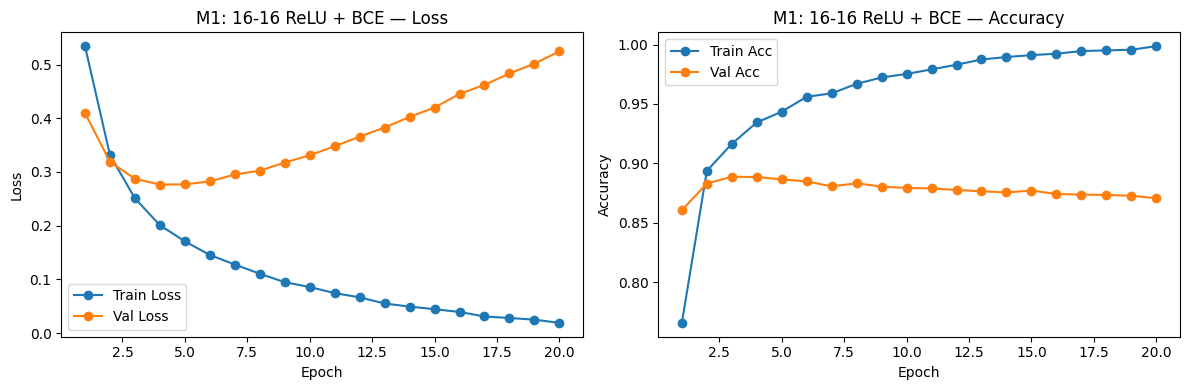

M1: 16-16 ReLU + BCE
Val  -> Acc: 0.8708 | Loss: 0.5246
Test -> Acc: 0.8594 | Loss: 0.5652
------------------------------------------------------------


In [42]:
scorebook = []

m1 = make_mlp(hidden_layers=2, units_list=[16,16], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r1 = train_and_plot(m1, "M1: 16-16 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r1)


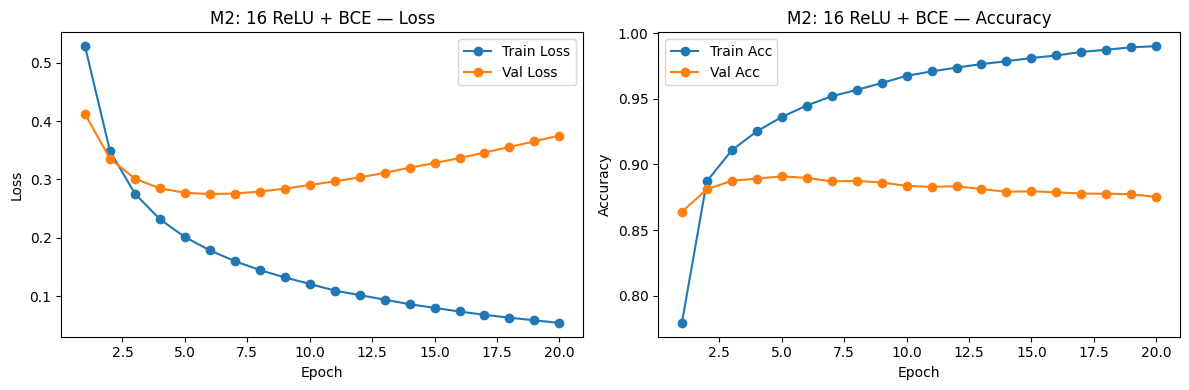

M2: 16 ReLU + BCE
Val  -> Acc: 0.8752 | Loss: 0.3755
Test -> Acc: 0.8659 | Loss: 0.4012
------------------------------------------------------------


In [43]:
m2 = make_mlp(hidden_layers=1, units_list=[16], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r2 = train_and_plot(m2, "M2: 16 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r2)


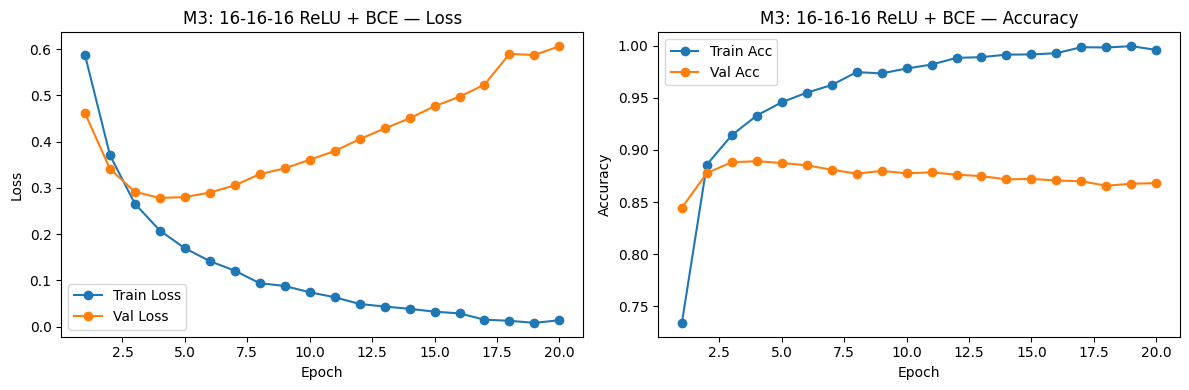

M3: 16-16-16 ReLU + BCE
Val  -> Acc: 0.8682 | Loss: 0.6066
Test -> Acc: 0.8602 | Loss: 0.6486
------------------------------------------------------------


In [44]:
m3 = make_mlp(hidden_layers=3, units_list=[16,16,16], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r3 = train_and_plot(m3, "M3: 16-16-16 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r3)


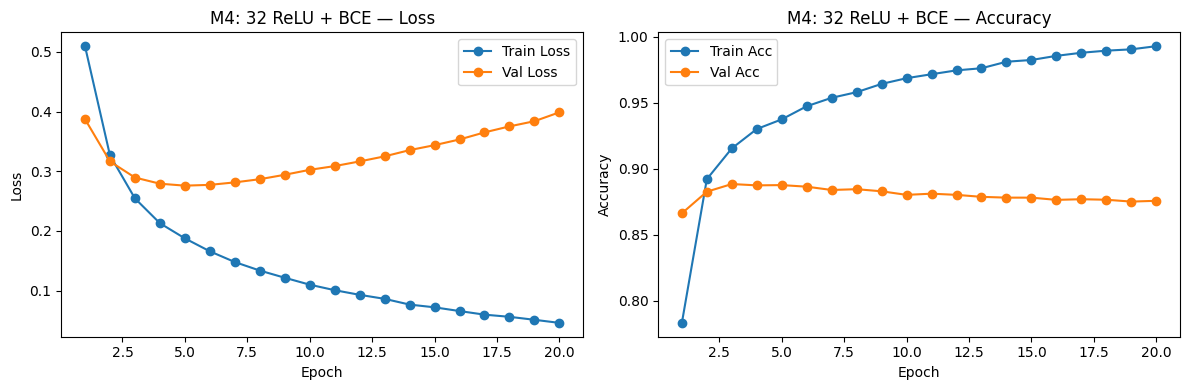

M4: 32 ReLU + BCE
Val  -> Acc: 0.8758 | Loss: 0.3987
Test -> Acc: 0.8661 | Loss: 0.4213
------------------------------------------------------------


In [45]:
m4 = make_mlp(hidden_layers=1, units_list=[32], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r4 = train_and_plot(m4, "M4: 32 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r4)


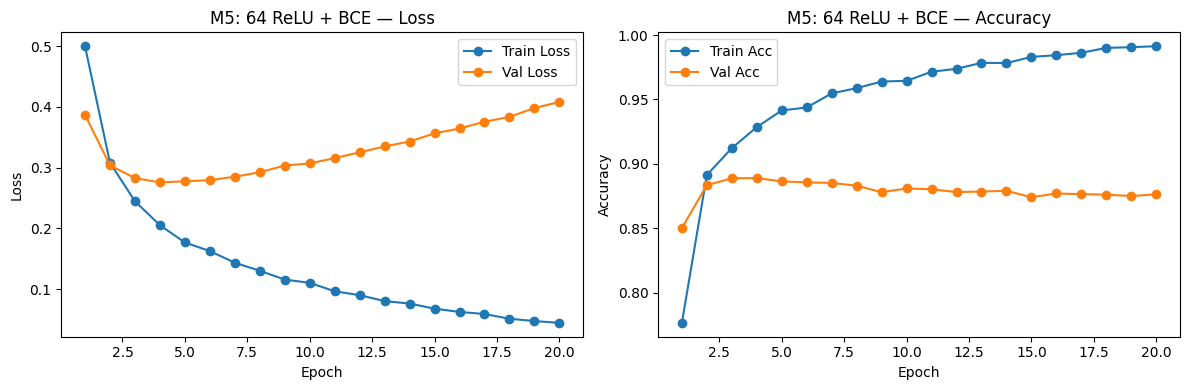

M5: 64 ReLU + BCE
Val  -> Acc: 0.8763 | Loss: 0.4080
Test -> Acc: 0.8663 | Loss: 0.4327
------------------------------------------------------------


In [46]:
m5 = make_mlp(hidden_layers=1, units_list=[64], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r5 = train_and_plot(m5, "M5: 64 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r5)


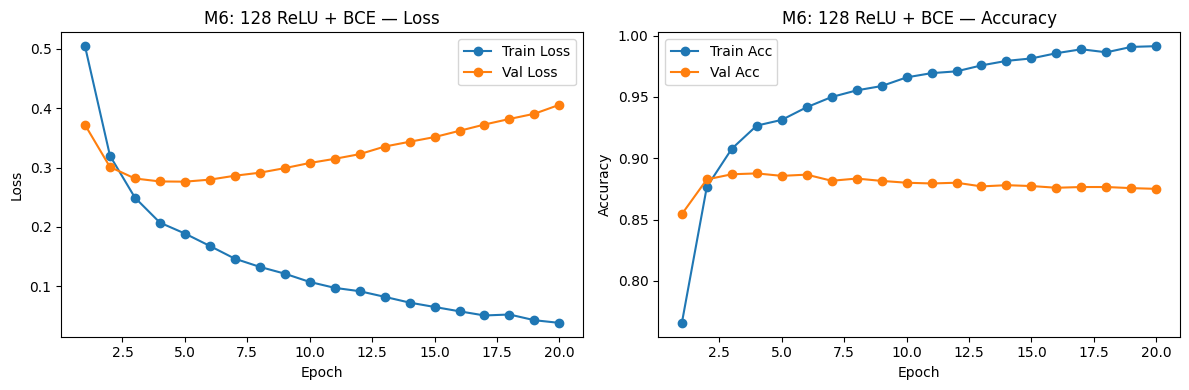

M6: 128 ReLU + BCE
Val  -> Acc: 0.8750 | Loss: 0.4057
Test -> Acc: 0.8680 | Loss: 0.4279
------------------------------------------------------------


In [47]:
m6 = make_mlp(hidden_layers=1, units_list=[128], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r6 = train_and_plot(m6, "M6: 128 ReLU + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r6)


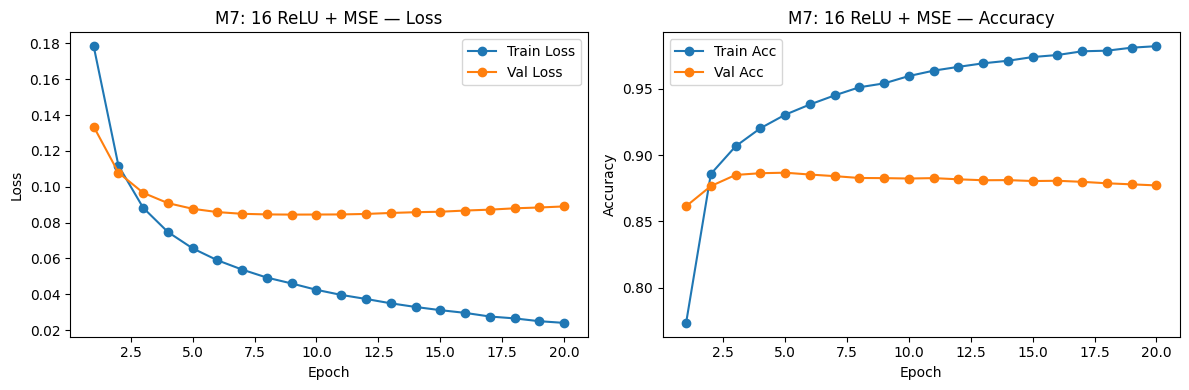

M7: 16 ReLU + MSE
Val  -> Acc: 0.8772 | Loss: 0.0890
Test -> Acc: 0.8707 | Loss: 0.0948
------------------------------------------------------------


In [48]:
m7 = make_mlp(hidden_layers=1, units_list=[16], activation="relu",
              use_dropout=0.0, l2_strength=0.0, loss_name="mse")
r7 = train_and_plot(m7, "M7: 16 ReLU + MSE", X_train, y_train, X_val, y_val)
scorebook.append(r7)


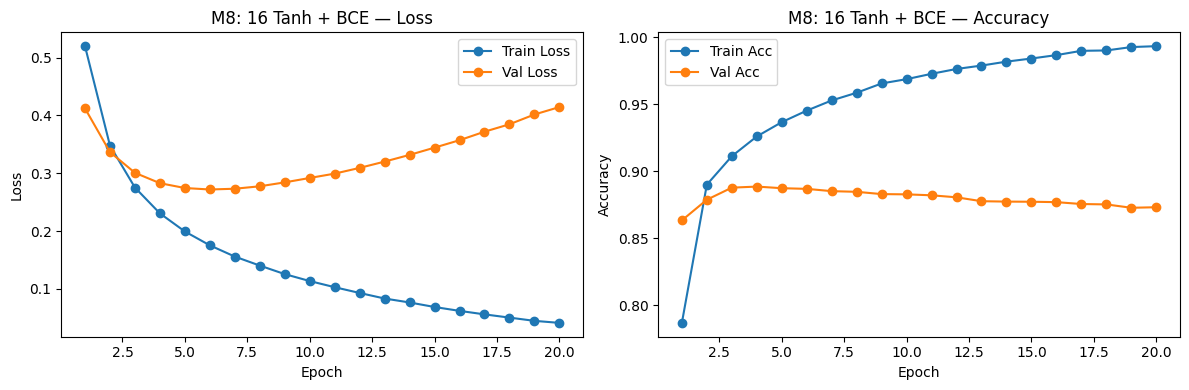

M8: 16 Tanh + BCE
Val  -> Acc: 0.8731 | Loss: 0.4145
Test -> Acc: 0.8639 | Loss: 0.4434
------------------------------------------------------------


In [49]:
m8 = make_mlp(hidden_layers=1, units_list=[16], activation="tanh",
              use_dropout=0.0, l2_strength=0.0, loss_name="binary_crossentropy")
r8 = train_and_plot(m8, "M8: 16 Tanh + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r8)


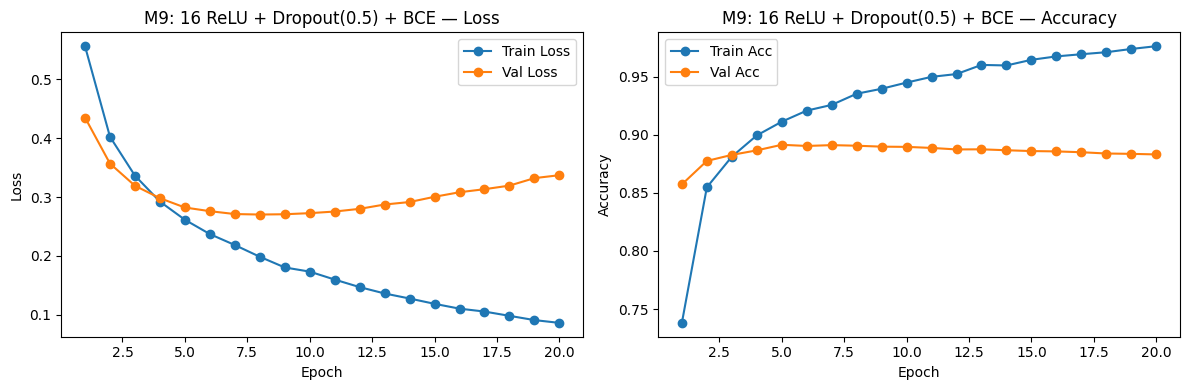

M9: 16 ReLU + Dropout(0.5) + BCE
Val  -> Acc: 0.8831 | Loss: 0.3371
Test -> Acc: 0.8738 | Loss: 0.3615
------------------------------------------------------------


In [50]:
m9 = make_mlp(hidden_layers=1, units_list=[16], activation="relu",
              use_dropout=0.5, l2_strength=0.0, loss_name="binary_crossentropy")
r9 = train_and_plot(m9, "M9: 16 ReLU + Dropout(0.5) + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r9)


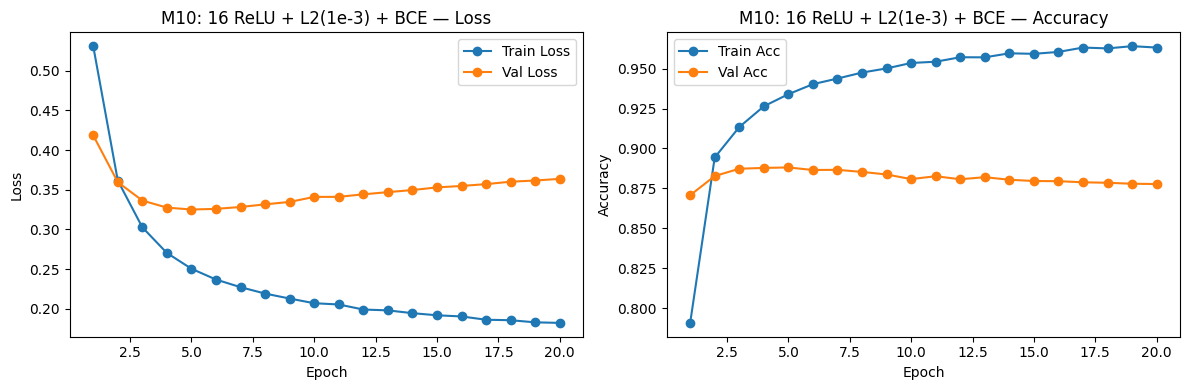

M10: 16 ReLU + L2(1e-3) + BCE
Val  -> Acc: 0.8777 | Loss: 0.3637
Test -> Acc: 0.8722 | Loss: 0.3776
------------------------------------------------------------


In [51]:
m10 = make_mlp(hidden_layers=1, units_list=[16], activation="relu",
               use_dropout=0.0, l2_strength=1e-3, loss_name="binary_crossentropy")
r10 = train_and_plot(m10, "M10: 16 ReLU + L2(1e-3) + BCE", X_train, y_train, X_val, y_val)
scorebook.append(r10)


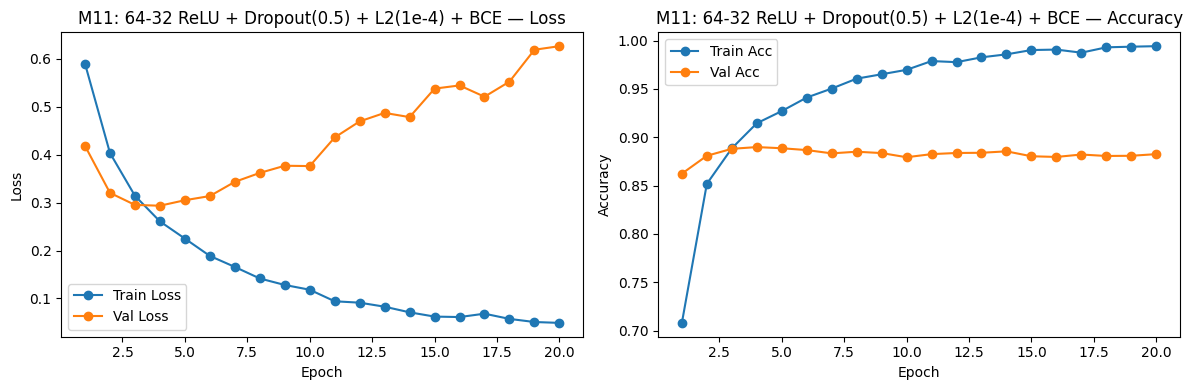

M11: 64-32 ReLU + Dropout(0.5) + L2(1e-4) + BCE
Val  -> Acc: 0.8826 | Loss: 0.6263
Test -> Acc: 0.8719 | Loss: 0.6684
------------------------------------------------------------


In [52]:
m11 = make_mlp(hidden_layers=2, units_list=[64,32], activation="relu",
               use_dropout=0.5, l2_strength=1e-4, loss_name="binary_crossentropy")
r11 = train_and_plot(m11, "M11: 64-32 ReLU + Dropout(0.5) + L2(1e-4) + BCE",
                     X_train, y_train, X_val, y_val)
scorebook.append(r11)


In [53]:

import pandas as pd

scores = pd.DataFrame(scorebook).sort_values(["val_acc", "test_acc"], ascending=False)
print("=== All Models (sorted by val_acc, then test_acc) ===")
print(scores.to_string(index=False))

best_val = scores.iloc[0]
print("\n=== Best by Validation Accuracy ===")
print(f"{best_val['name']}  |  val_acc={best_val['val_acc']:.4f}  test_acc={best_val['test_acc']:.4f}")

# optional: also report best test
best_test = scores.sort_values(["test_acc","val_acc"], ascending=False).iloc[0]
print("\n=== Best by Test Accuracy ===")
print(f"{best_test['name']}  |  val_acc={best_test['val_acc']:.4f}  test_acc={best_test['test_acc']:.4f}")

# short plain-english wrap-up for your report
print("\n--- CONCLUSION ---")
print("I tried depth (1/2/3 layers), width (16/32/64/128), loss (BCE vs MSE),")
print("activation (ReLU vs Tanh), and regularization (Dropout/L2).")
print(f"Best validation model was: {best_val['name']} with val_acc={best_val['val_acc']:.4f} and test_acc={best_val['test_acc']:.4f}.")
print("Binary crossentropy generally beat MSE. ReLU usually beat Tanh.")
print("Going wider/deeper helped until it started to overfit; dropout/L2 helped control that on bigger nets.")


=== All Models (sorted by val_acc, then test_acc) ===
                                           name  val_acc  val_loss  test_acc  test_loss
               M9: 16 ReLU + Dropout(0.5) + BCE   0.8831  0.337127   0.87384   0.361523
M11: 64-32 ReLU + Dropout(0.5) + L2(1e-4) + BCE   0.8826  0.626314   0.87188   0.668449
                  M10: 16 ReLU + L2(1e-3) + BCE   0.8777  0.363691   0.87220   0.377614
                              M7: 16 ReLU + MSE   0.8772  0.089018   0.87072   0.094800
                              M5: 64 ReLU + BCE   0.8763  0.408025   0.86628   0.432682
                              M4: 32 ReLU + BCE   0.8758  0.398671   0.86612   0.421329
                              M2: 16 ReLU + BCE   0.8752  0.375481   0.86588   0.401222
                             M6: 128 ReLU + BCE   0.8750  0.405678   0.86796   0.427912
                              M8: 16 Tanh + BCE   0.8731  0.414544   0.86388   0.443383
                           M1: 16-16 ReLU + BCE   0.8708  0.524601

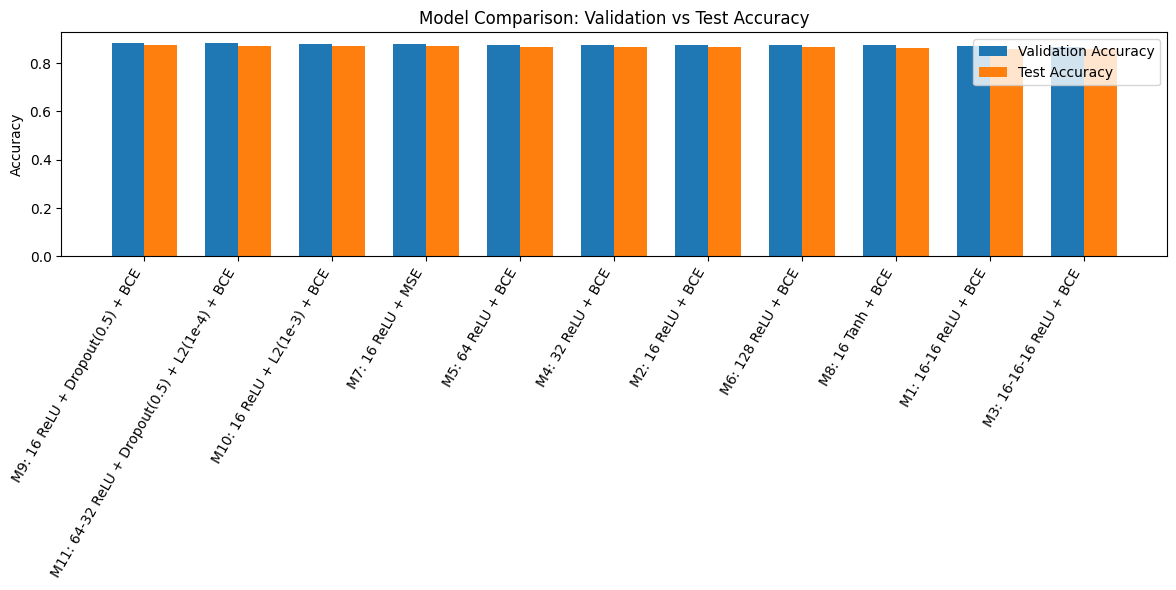

In [54]:
names = scores["name"]
val_values = scores["val_acc"]
test_values = scores["test_acc"]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, val_values, width, label='Validation Accuracy')
plt.bar(x + width/2, test_values, width, label='Test Accuracy')

plt.xticks(x, names, rotation=60, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Validation vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()